In [13]:
import numpy as np

# **Dataset Preprocessing**

In [4]:
import datasets

sst_dataset = datasets.load_dataset("sst", trust_remote_code=True)

In [5]:
print("SST Dataset: ", sst_dataset)

SST Dataset:  DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 2210
    })
})


We only care about the sentence and label fields not the tokens and tree. So we are going to exclude them from the processing


In [ ]:
removed_columns = ['tokens', 'tree']
sst_dataset = sst_dataset.remove_columns(removed_columns)
print("After removal of tokens and tree columns:")
print(sst_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2210
    })
})


### **Function to convert the scores to classes** 

0 -> very negative, 1 -> negative, 2 -> neutral, 3 -> positive, -> very positive 

In [11]:
def score_to_class(score):
    mappingFn = {
        (0, 0.2): 0,
        (0.2, 0.4): 1,
        (0.4, 0.6): 2,
        (0.6, 0.8): 3,
        (0.8, 1.0): 4
    }
    
    for range, category in mappingFn.items():
        if range[0] <= score <= range[1]:
            return category
    else:
        return "undefined range!"


#### Splitting the dataset into train, validation and test sets

In [ ]:
train_dataset = sst_dataset["train"]
validation_dataset = sst_dataset["validation"]
test_dataset = sst_dataset["test"]

In [14]:
train_labels = train_dataset["label"]
categorized_labels_train = []
for label in train_labels:
    categorized_labels_train.append(score_to_class(label))

In [15]:
test_labels = test_dataset["label"]
categorized_labels_test = []
for label in test_labels:
    categorized_labels_test.append(score_to_class(label))

## **Part 2.1:** Naive Bayes Classification

In [ ]:
class NaiveBayes:

    def fit(self, X, Y, vocab):
        X = np.array(X)
        Y = np.array(Y)
        Documents = X.shape[0]
        self.classes, documentsPerClass = np.unique(Y, return_counts=True)

        # 1) Prior probabilities P(C)
        self.prior = np.zeros(len(self.classes))
        for idx, Class in enumerate(self.classes):
            self.prior[idx] = np.log(documentsPerClass[idx] / Documents)

        # Creating an array of big documents for each class
        self.big_documents = np.zeros((len(self.classes), len(vocab)))
        for idx, Class in enumerate(self.classes):
            for doc_idx, (x, y) in enumerate(zip(X, Y)):
                if y == Class:
                    for word_idx, word in enumerate(vocab):
                        if word in x.split():
                            self.big_documents[idx][word_idx] += 1

        # 2) Likelihood probablities P(W | C) with Laplace Smoothing
        self.likelihood = np.zeros((len(vocab), len(self.classes)))
        for idx, word in enumerate(vocab):
            for idx2, Class in enumerate(self.classes):
                self.likelihood[idx][idx2] = np.log((self.big_documents[idx2][idx] + 1) /
                                                    (np.sum(self.big_documents[idx2]) + len(vocab)))

        return self.prior, self.likelihood, vocab

    # 3) Inferrence
    def predict(self, X, vocab):
        sums = np.zeros(len(self.classes))
        vocabList = np.array(list(vocab.keys()))  
        for idx, Class in enumerate(self.classes):
            sums[idx] += self.prior[idx]
            words = X.split()
            
            for word in words:
                if word in vocabList:
                    wordIndex = np.where(vocabList == word)[0]  # Get the first index
                    sums[idx] += self.likelihood[wordIndex, idx]  # Correct indexing

        return self.classes[np.argmax(sums)]


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
import string

def custom_tokenizer(text):
    text_no_punctuation = "".join([char for char in text if char not in string.punctuation])
    tokens = text_no_punctuation.split()
    return tokens

count_vectorizer = CountVectorizer(
    stop_words="english",
    token_pattern=r'\b\w\w+\b',
    tokenizer=custom_tokenizer,
    lowercase=True
)

train_text = count_vectorizer.fit(train_dataset["sentence"])


d:\Apps files\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [19]:
vocab = train_text.vocabulary_

In [ ]:
model = NaiveBayes()
model.fit(train_dataset["sentence"], categorized_labels_train, vocab)

(array([-2.0572184 , -1.34862339, -1.66033704, -1.3028004 , -1.89213865]),
 array([[ -9.38210641,  -8.96443983, -10.18693567,  -8.79603632,
          -8.7524234 ],
        [-10.0752536 , -10.35073419, -10.18693567,  -8.79603632,
         -10.13871776],
        [ -9.38210641, -10.35073419,  -9.49378849,  -9.01917987,
         -10.13871776],
        ...,
        [-10.0752536 , -10.35073419, -10.18693567, -10.40547423,
         -10.13871776],
        [ -9.38210641, -10.35073419, -10.18693567, -10.40547423,
         -10.13871776],
        [ -9.38210641, -10.35073419, -10.18693567, -10.40547423,
         -10.13871776]]),
 {'rock': 11930,
  'destined': 3796,
  '21st': 92,
  'century': 2273,
  's': 12088,
  'new': 9519,
  'conan': 2871,
  'going': 6085,
  'make': 8622,
  'splash': 13347,
  'greater': 6221,
  'arnold': 895,
  'schwarzenegger': 12281,
  'jeanclaud': 7679,
  'van': 15338,
  'damme': 3450,
  'steven': 13564,
  'segal': 12412,
  'gorgeously': 6134,
  'elaborate': 4528,
  'continua

In [21]:
predict_array = np.zeros(len(test_dataset["sentence"]))
for i in range (0, len(test_dataset["sentence"])-1):
  predict_array[i] = model.predict(test_dataset["sentence"][i], vocab)

C:\Users\KimoStore\AppData\Local\Temp\ipykernel_5180\3279047324.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sums[idx] += self.likelihood[wordIndex, idx]  # Correct indexing


In [47]:
from prettytable import PrettyTable

table = PrettyTable()

table.field_names = ["Sentence", "Prediction", "Label"]
for i in range(10):
    sentence = test_dataset["sentence"][i]
    prediction = predict_array[i]
    label = score_to_class(test_dataset["label"][i])
    table.add_row([sentence, prediction, float(label)])  

print(table)

+--------------------------------------------------------------------------------------------------------------------------------------------+------------+-------+
|                                                                  Sentence                                                                  | Prediction | Label |
+--------------------------------------------------------------------------------------------------------------------------------------------+------------+-------+
|                                                       Effective but too-tepid biopic                                                       |    3.0     |  2.0  |
|                         If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .                          |    3.0     |  3.0  |
|             Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .              |    3.0     |  4.0  |
| The film provi

In [22]:
from sklearn.metrics import accuracy_score
print(f" Accuracy : {accuracy_score(categorized_labels_test, predict_array)*100}")

 Accuracy : 39.321266968325794


### **Comparison with scikit-learn**

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(train_dataset["sentence"], categorized_labels_train)
y_pred = model.predict(test_dataset["sentence"])

In [25]:
print(f" Accuracy : {accuracy_score(categorized_labels_test, y_pred)*100}")

 Accuracy : 40.90497737556561


## **Part 2.3:** Implementing Confusion Matrix and Evaluation Metrics from scratch

2.3.1: Confusion Matrix

In [26]:
def generateConfusionMatrix(predicted_labels, gold_labels):
    predicted_labels = np.array(predicted_labels)
    gold_labels = np.array(gold_labels)
    classes = np.unique(gold_labels)
    n = len(classes)
    label_to_index = {label: i for i, label in enumerate(classes)}  # Map labels to integer indices
    confusionMatrix = np.zeros((n, n))

    for gold_label, predicted_label in zip(gold_labels, predicted_labels):
        gold_index = label_to_index[gold_label]
        predicted_index = label_to_index[predicted_label]
        confusionMatrix[gold_index, predicted_index] += 1

    return confusionMatrix

In [49]:
result = generateConfusionMatrix(predict_array, categorized_labels_test)
print("Implemented Confusion Matrix: ")
print("-----------------------------")
print(result)

Implemented Confusion Matrix: 
-----------------------------
[[ 32. 169.  19.  54.   5.]
 [ 30. 368.  53. 164.  18.]
 [ 13. 147.  42. 168.  19.]
 [  7.  91.  26. 341.  45.]
 [  3.  46.  13. 251.  86.]]


2.3.2: Evaluation Metrics:

In [52]:
def performance_analysis(confusionMatrix):

  n = confusionMatrix.shape[0] #numberOfClasses
  precision = np.zeros(n)
  recall = np.zeros(n)
  f1_score = np.zeros(n)
  for i in range (0,n):
    precision[i] = confusionMatrix[i][i] / np.sum(confusionMatrix[:, i])
    recall[i] = confusionMatrix[i][i] / np.sum(confusionMatrix[i,:])
    f1_score[i] = (2*precision[i]*recall[i]) / (precision[i] + recall[i])

  macroaveraged_precision = np.sum(precision) / n
  macroaveraged_recall = np.sum(recall) / n
  macroaveraged_f1 = np.sum(f1_score) / n

  return precision, recall, f1_score, macroaveraged_precision, macroaveraged_recall, macroaveraged_f1

In [53]:
precision, recall, f1, macroP, macroR, macroF1 = performance_analysis(result)

table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["Precision", precision])
table.add_row(["Recall", recall])
table.add_row(["F1 Score", f1])
table.add_row(["Macro-averaged Precision", macroP])
table.add_row(["Macro-averaged Recall", macroR])
table.add_row(["Macro-averaged F1 Score", macroF1])

print(table)

+--------------------------+----------------------------------------------------------+
|          Metric          |                          Value                           |
+--------------------------+----------------------------------------------------------+
|        Precision         | [0.37647059 0.44823386 0.2745098  0.34867076 0.49710983] |
|          Recall          | [0.11469534 0.58135861 0.10796915 0.66862745 0.21553885] |
|         F1 Score         | [0.17582418 0.50618982 0.15498155 0.45833333 0.3006993 ] |
| Macro-averaged Precision |                    0.388998967307524                     |
|  Macro-averaged Recall   |                    0.3376378800131117                    |
| Macro-averaged F1 Score  |                   0.31920563617105036                    |
+--------------------------+----------------------------------------------------------+


Plotting the confusion Matrix

In [30]:
import matplotlib.pyplot as plt
def plotMatrix(confusion_matrix):
  plt.imshow(confusion_matrix, cmap='viridis')
  for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
          plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='white')

  plt.colorbar(label='Count')
  plt.xlabel('Predicted Label')
  plt.ylabel('Gold Label')
  plt.title('Confusion Matrix')
  plt.show()

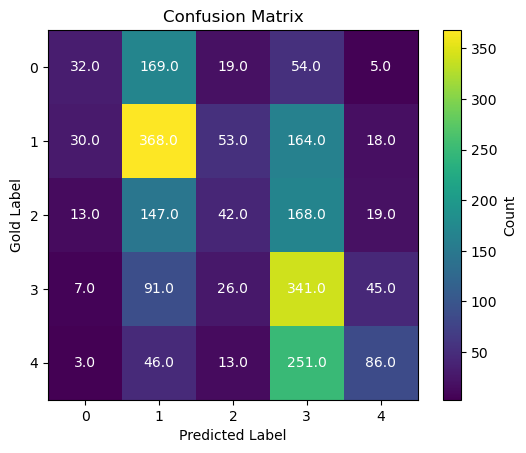

In [31]:
plotMatrix(result)

Comparing the confusion matrix from scikit-learn

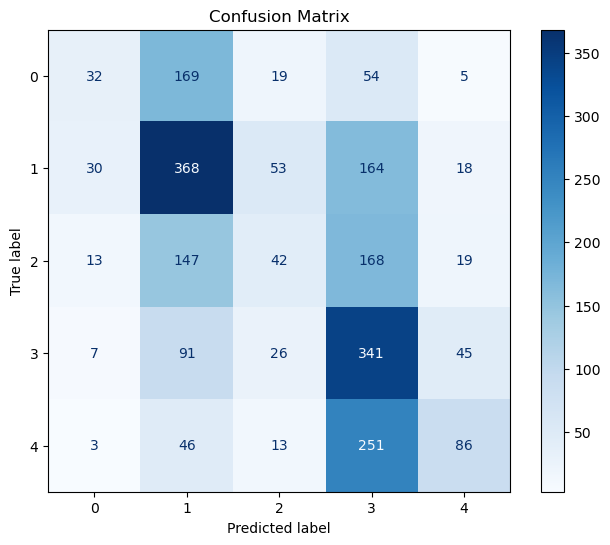

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusionMatrix = confusion_matrix(categorized_labels_test, predict_array)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

fig, ax = plt.subplots(figsize=(8, 6))
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Comparing Evaluation Metrics with scikit-learn

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score
from prettytable import PrettyTable

precision = precision_score(categorized_labels_test, predict_array, average=None)  # Per-class precision
recall = recall_score(categorized_labels_test, predict_array, average=None)      # Per-class recall
f1 = f1_score(categorized_labels_test, predict_array, average=None)             # Per-class F1-score

macro_precision = precision_score(categorized_labels_test, predict_array, average='macro')
macro_recall = recall_score(categorized_labels_test, predict_array, average='macro')
macro_f1 = f1_score(categorized_labels_test, predict_array, average='macro')


table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score"]
for i in range(len(precision)):
    table.add_row([f"Class {i}", precision[i], recall[i], f1[i]])
table.add_row(["Macro Avg", macro_precision, macro_recall, macro_f1])

print("Evaluation Metrics:")
print(table)

Evaluation Metrics:
+-----------+---------------------+---------------------+---------------------+
|   Class   |      Precision      |        Recall       |       F1-Score      |
+-----------+---------------------+---------------------+---------------------+
|  Class 0  |  0.3764705882352941 | 0.11469534050179211 | 0.17582417582417584 |
|  Class 1  |  0.4482338611449452 |  0.5813586097946287 |  0.5061898211829436 |
|  Class 2  | 0.27450980392156865 | 0.10796915167095116 | 0.15498154981549817 |
|  Class 3  |  0.3486707566462168 |  0.6686274509803921 |  0.4583333333333333 |
|  Class 4  | 0.49710982658959535 | 0.21553884711779447 |  0.3006993006993007 |
| Macro Avg |  0.388998967307524  |  0.3376378800131117 | 0.31920563617105036 |
+-----------+---------------------+---------------------+---------------------+


Extra:

In [51]:
from sklearn.metrics import classification_report


report = classification_report(categorized_labels_test, predict_array, target_names=None, digits=4)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0     0.3765    0.1147    0.1758       279
           1     0.4482    0.5814    0.5062       633
           2     0.2745    0.1080    0.1550       389
           3     0.3487    0.6686    0.4583       510
           4     0.4971    0.2155    0.3007       399

    accuracy                         0.3932      2210
   macro avg     0.3890    0.3376    0.3192      2210
weighted avg     0.3944    0.3932    0.3545      2210

